# Decision Trees Based on Top 3 Events and Split by Gender
Preksha Sarda

### Data Preprocessing

In [28]:
#import statements
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')
df.head()

,Event,Conf_Rank,Time,Name,School,Standard,Date,Gender,Division,Season,SeasonYear,Time_Adj,Time_Sec,Div_Rank,NCAA_Rank,ID,Power_Tot,Power,Record,Points
0,50 Freestyle SCY Male,-1,21.22,Ben Beldner,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.220000,21.22,-1,-1,394588,22.71,20.52,17.63,573.483330
1,50 Freestyle SCY Male,-1,20.87,Justin Meyn,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:20.870000,20.87,-1,-1,471360,10.06,20.80,17.63,602.822689
2,50 Freestyle SCY Male,-1,21.31,Joshua Franco,New Jersey Institute of Technology,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.310000,21.31,-1,-1,395308,12.40,22.05,17.63,566.247878
3,50 Freestyle SCY Male,-1,21.05,Gabe Laracuente,UMBC,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.050000,21.05,-1,-1,404642,13.77,23.93,17.63,587.490213
4,50 Freestyle SCY Male,-1,21.70,Ryan Board,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.700000,21.70,-1,-1,422211,18.21,28.82,17.63,536.262879


### Filter to Top 3 Events

In [3]:
#format to make future calculations
df.loc[:,'isHS'] = df.loc[:,'Division'] == 'HS'
df.loc[:, 'isHS'] = 'Col'  # Default to 'Col'

df.loc[df['Division'] == 'HS', 'isHS'] = 'HS'

#group the data and create pivot table based on points
grouped = pd.pivot_table(df,index=['ID','Event'],columns='isHS',values='Points',aggfunc='max').reset_index()
grouped.dtypes

#find top 3 event by unique id
grouped = grouped.dropna()

# Step 1: Filter the rows where 'isHS' == 0 (we use the '0' column here)
filtered = grouped[grouped['Col'].notna()]  # Ensure we're only looking at rows where Points (for isHS == 0) are not NaN

# Step 2: Sort the filtered DataFrame by the '0' column (Points for isHS == 0) in descending order
sorted_filtered = filtered.sort_values(by='Col', ascending=False)

# Step 3: For each unique ID, get the top 3 rows based on the '0' column (Points for isHS == 0)
top_3_per_id = sorted_filtered.groupby('ID').head(3)

# Step 4: Count the number of entries for each 'ID' and filter to keep only those with at least 3 entries
valid_ids = top_3_per_id.groupby('ID').size()
valid_ids = valid_ids[valid_ids >= 3].index  # IDs with at least 3 entries

# Step 5: Filter the DataFrame to keep only the valid IDs
top_3_valid_ids = top_3_per_id[top_3_per_id['ID'].isin(valid_ids)]

# Display the result
print(top_3_valid_ids.sort_values(by="ID"))

isHS         ID                           Event         Col          HS
15         3480         200 Backstroke SCY Male  462.749670  656.537006
11         3480          100 Freestyle SCY Male  443.522321  585.648075
8          3480         100 Backstroke SCY Male  496.925131  604.120059
34         7361           50 Freestyle SCY Male  462.330341  551.368000
30         7361          200 Freestyle SCY Male  512.727092  707.657252
...         ...                             ...         ...         ...
163234  2968147       100 Breaststroke SCY Male  516.504001  312.104197
163243  2968147  200 Individual Medley SCY Male  477.594308  334.388650
163261  3008853         50 Freestyle SCY Female  542.245286  265.838311
163262  3008853        500 Freestyle SCY Female  428.375514  198.685297
163256  3008853        200 Freestyle SCY Female  467.686020  209.716608

[28260 rows x 4 columns]


/tmp/ipykernel_613810/3938996755.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Col' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, 'isHS'] = 'Col'  # Default to 'Col'
/tmp/ipykernel_613810/3938996755.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped = pd.pivot_table(df,index=['ID','Event'],columns='isHS',values='Points',aggfunc='max').reset_index()


In [8]:
#rename because I don't wanna type

top3 = pd.merge(df[['ID', 'Event', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  top_3_valid_ids, 
                  on=['ID', 'Event'], 
                  how='left')

top3.head()

,ID,Event,School,Standard,Gender,Division,Season,Col,HS
0,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,609.808493,573.48333
1,471360,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,NaN,NaN
2,395308,50 Freestyle SCY Male,New Jersey Institute of Technology,NA,M,HS,00_01,NaN,NaN
3,404642,50 Freestyle SCY Male,UMBC,NA,M,HS,00_01,NaN,NaN
4,422211,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,NaN,NaN


### Start work to split by gender
Goal: to see if the importances between men and women differ

In [95]:
top3['Difference'] = top3.Col - top3.HS
female = top3[top3.Gender == 'F'].dropna().copy()
male = top3[top3.Gender == 'M'].dropna().copy()

display(female.head())
display(male.head())

,ID,Event,School,Standard,Gender,Division,Season,Col,HS,Difference
3315,508060,50 Freestyle SCY Female,UMBC,NA,F,HS,00_01,633.328502,596.385381,36.943121
3317,611007,50 Freestyle SCY Female,Maine,NA,F,HS,00_01,572.638367,559.535554,13.102813
3318,353834,50 Freestyle SCY Female,UMBC,NA,F,HS,00_01,557.503345,551.465455,6.037890
3319,367276,50 Freestyle SCY Female,Stony Brook,NA,F,HS,00_01,550.135555,504.385078,45.750477
3320,493054,50 Freestyle SCY Female,Maine,NA,F,HS,00_01,550.799970,537.068755,13.731215


,ID,Event,School,Standard,Gender,Division,Season,Col,HS,Difference
0,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,609.808493,573.483330,36.325164
5,550482,50 Freestyle SCY Male,Maine,NA,M,HS,00_01,576.738667,497.469995,79.268673
21,365029,50 Freestyle SCY Male,Gardner-Webb University,NA,M,HS,00_01,642.616448,597.653204,44.963244
22,399065,50 Freestyle SCY Male,Gardner-Webb University,NA,M,HS,00_01,598.510669,549.832157,48.678512
25,469880,50 Freestyle SCY Male,Bellarmine,NA,M,HS,00_01,572.673325,532.573010,40.100316


### Gender: Female


I had weird accuracy ratings without cross validation and just by generating random train and teste set, so this time I will use cross validation to do it

In [105]:
# bin quality scores into improved/not improved
female['rating'] = pd.cut(female.Difference,bins=[-float("inf"), 0, float("inf")],labels=['Worsened','Improved'])
female.head(3)

,ID,Event,School,Standard,Gender,Division,Season,Col,HS,Difference,rating
3315,508060,50 Freestyle SCY Female,UMBC,NA,F,HS,00_01,633.328502,596.385381,36.943121,Improved
3317,611007,50 Freestyle SCY Female,Maine,NA,F,HS,00_01,572.638367,559.535554,13.102813,Improved
3318,353834,50 Freestyle SCY Female,UMBC,NA,F,HS,00_01,557.503345,551.465455,6.037890,Improved


In [106]:
female.rating.value_counts()


rating
Improved    43421
Worsened    19853
Name: count, dtype: int64

We see that a lot of women actually improved, which suggests that there will be different features that are more important!

In [107]:
# select attributes and target
X = pd.DataFrame(female[['Event', 'Standard', 'Division', 'Season']])
y = female.rating

In [108]:
female['Event'].str.contains(r'\s+male', case=False, na=False).any()

np.False_

In [109]:
X.head()

for col in X.columns:
    print(col)
X.Event.value_counts()

Event
Standard
Division
Season


Event
200 Freestyle SCY Female            8796
100 Freestyle SCY Female            7932
500 Freestyle SCY Female            6199
50 Freestyle SCY Female             6059
200 Individual Medley SCY Female    5191
                                    ... 
500 Freestyle SCY Male                 0
800 Freestyle LCM Female               0
800 Freestyle LCM Male                 0
800 Freestyle SCM Female               0
800 Freestyle SCM Male                 0
Name: count, Length: 94, dtype: int64

In [110]:
#convert to ohe because of all the non numerical values
X = pd.get_dummies(X)
X.head()


,Event_100 Backstroke LCM Female,Event_100 Backstroke LCM Male,Event_100 Backstroke SCM Female,Event_100 Backstroke SCM Male,Event_100 Backstroke SCY Female,Event_100 Backstroke SCY Male,Event_100 Breaststroke LCM Female,Event_100 Breaststroke LCM Male,Event_100 Breaststroke SCM Female,Event_100 Breaststroke SCM Male,...,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
3315,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3317,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3318,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3319,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3320,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False


In [111]:
dtree = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
dtreeCV = GridSearchCV(dtree,
                      param_grid=parameters,
                      return_train_score=True,
                      n_jobs=-1)
dtreeCV.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [112]:
dtreeCV.best_params_

{'max_depth': 3}

In [113]:
acc = dtreeCV.score(X,y)
print('accuracy on training set',round(acc,2))

accuracy on training set 0.69


In [114]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.686238,0.686238
1,2,0.688020,0.686759
2,3,0.689430,0.688150
3,4,0.689912,0.688118
4,5,0.690762,0.678383
5,6,0.691568,0.669912
6,7,0.691615,0.668158
7,8,0.691900,0.645382
8,9,0.692085,0.641715
9,10,0.692125,0.642996


<Axes: xlabel='depth'>

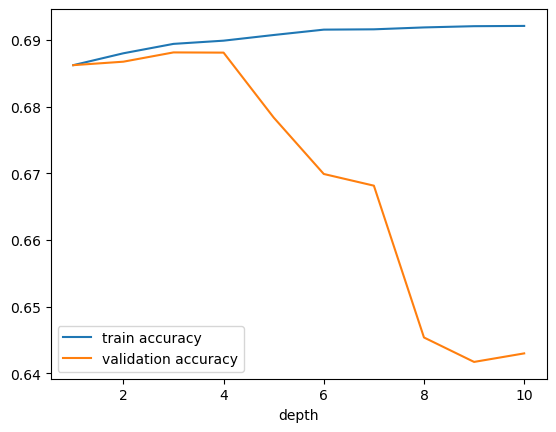

In [117]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

### Feature Importances: Female

In [119]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
female_importances = pd.DataFrame()
female_importances['features'] = X.columns
female_importances['importances'] = importances
female_importances.sort_values(by='importances', ascending = False)

,features,importances
95,Standard_B,0.489329
28,Event_1000 Freestyle SCY Female,0.250350
58,Event_200 Freestyle SCY Female,0.205652
100,Division_II,0.050808
52,Event_200 Butterfly SCY Female,0.001986
...,...,...
103,Season_19_20,0.000000
104,Season_20_21,0.000000
105,Season_21_22,0.000000
106,Season_22_23,0.000000


### Results: Female

So what we see is that people in Standard B, swim 1000 freestyle (SCY), or swim 200 freestyle (SCY) are most likely to improve from high school to college.

### Gender: Male

We should be able to run very similar commands to men that we did for women!

In [124]:
# bin quality scores into improved/not improved
male['rating'] = pd.cut(male.Difference,bins=[-float("inf"), 0, float("inf")],labels=['Worsened','Improved'])
male.head(3)

,ID,Event,School,Standard,Gender,Division,Season,Col,HS,Difference,rating
0,394588,50 Freestyle SCY Male,Binghamton,NA,M,HS,00_01,609.808493,573.483330,36.325164,Improved
5,550482,50 Freestyle SCY Male,Maine,NA,M,HS,00_01,576.738667,497.469995,79.268673,Improved
21,365029,50 Freestyle SCY Male,Gardner-Webb University,NA,M,HS,00_01,642.616448,597.653204,44.963244,Improved


In [126]:
male.rating.value_counts()

rating
Improved    40288
Worsened     8058
Name: count, dtype: int64

we see a lot of men also improve from high school to college

In [127]:
# select attributes and target
X_men = pd.DataFrame(male[['Event', 'Standard', 'Division', 'Season']])
y_men = male.rating

In [128]:
#convert to ohe because of all the non numerical values
X_men = pd.get_dummies(X_men)
X_men.head()

,Event_100 Backstroke LCM Female,Event_100 Backstroke LCM Male,Event_100 Backstroke SCM Female,Event_100 Backstroke SCM Male,Event_100 Backstroke SCY Female,Event_100 Backstroke SCY Male,Event_100 Breaststroke LCM Female,Event_100 Breaststroke LCM Male,Event_100 Breaststroke SCM Female,Event_100 Breaststroke SCM Male,...,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
21,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
22,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
25,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False


In [129]:
dtree_men = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
dtreeCV_men = GridSearchCV(dtree_men,
                      param_grid=parameters,
                      return_train_score=True,
                      n_jobs=-1)
dtreeCV_men.fit(X_men, y_men)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [135]:
dtreeCV_men.best_params_

{'max_depth': 2}

In [136]:
acc = dtreeCV_men.score(X_men,y_men)
print('accuracy on training set',round(acc,2))

accuracy on training set 0.84


In [137]:
results_men = pd.DataFrame()
results_men['depth'] = parameters['max_depth']
results_men['train accuracy'] = dtreeCV_men.cv_results_['mean_train_score']
results_men['validation accuracy'] = dtreeCV_men.cv_results_['mean_test_score']
results_men

,depth,train accuracy,validation accuracy
0,1,0.834226,0.833037
1,2,0.836248,0.834050
2,3,0.836341,0.826376
3,4,0.837231,0.762543
4,5,0.837231,0.762543
5,6,0.837256,0.762543
6,7,0.837856,0.744963
7,8,0.838296,0.729927
8,9,0.838575,0.718469
9,10,0.838585,0.717228


<Axes: xlabel='depth'>

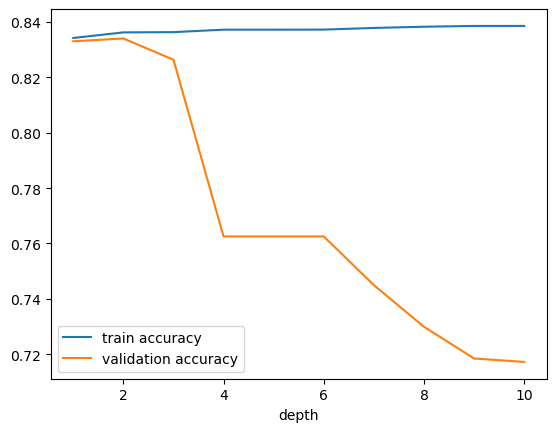

In [138]:
results_men.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

### Feature Importances: Male

In [139]:
dtree_best_men = dtreeCV_men.best_estimator_
importances_men = dtree_best_men.feature_importances_
male_importances = pd.DataFrame()
male_importances['features'] = X_men.columns
male_importances['importances'] = importances_men
male_importances.sort_values(by='importances', ascending = False)

,features,importances
29,Event_1000 Freestyle SCY Male,0.761968
95,Standard_B,0.200241
100,Division_II,0.037791
0,Event_100 Backstroke LCM Female,0.000000
4,Event_100 Backstroke SCY Female,0.000000
...,...,...
103,Season_19_20,0.000000
104,Season_20_21,0.000000
105,Season_21_22,0.000000
106,Season_22_23,0.000000


### Results: Male
So what we see is that men in the 1000 freestyle SCY event  are the most likely to improve -- that is that is bhy far the best indicator of improvement from high school to college.

### Overall Results

Both men and women whose top 3 events inlcude the 1000 freestyle (SCY) are likely to improve from high school to college. Men and women in standard B are also liely to improve, although that is more of an indicator for women than men. 